In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


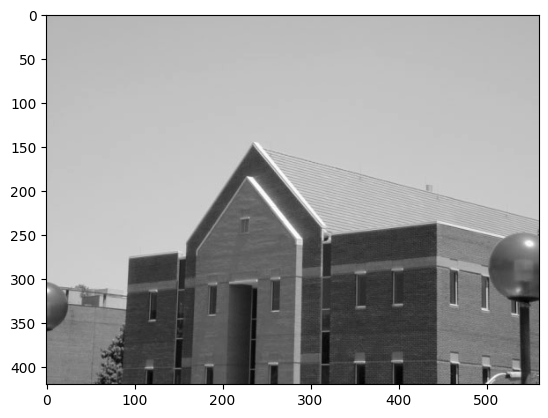

In [ ]:
input_image = cv2.imread('/content/drive/MyDrive/DIP/assignment 3/building.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(input_image, 'gray')

a) Sobel Operator

In [ ]:
def sobelOperator(input_image):

    Gx = np.array([[-1, -2, -1], [0, 0, 0],[ 1, 2, 1]])
    Gy = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

    [rows, columns] = np.shape(input_image)
    gradient_x = np.zeros(shape=(rows, columns))
    gradient_y = np.zeros(shape=(rows, columns))
    sobel_filtered_image = np.zeros(shape=(rows, columns))

    for i in range(rows - 2):
        for j in range(columns - 2):
            gx = np.sum(np.multiply(Gx, input_image[i:i + 3, j:j + 3]))
            gy = np.sum(np.multiply(Gy, input_image[i:i + 3, j:j + 3]))
            gradient_x[i + 1, j + 1] = gx
            gradient_y[i + 1, j + 1] = gy
            sobel_filtered_image[i + 1, j + 1] = np.sqrt(gx ** 2 + gy ** 2)

    return gradient_x, gradient_y, sobel_filtered_image

#On the input image, apply the sobel operator, which is both gradient x and y
gradient_x, gradient_y, sobel_image = sobelOperator(input_image)

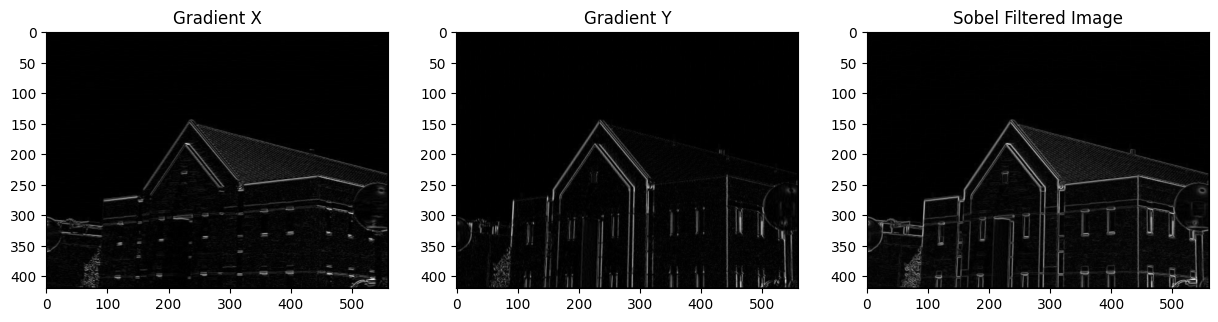

In [ ]:
#Outputs of gradient x, y and sobel filtered
fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axis[0].imshow(np.abs(gradient_x), cmap='gray')
axis[0].set_title('Gradient X')
axis[1].imshow(np.abs(gradient_y), cmap='gray')
axis[1].set_title('Gradient Y')
axis[2].imshow(sobel_image, cmap='gray')
axis[2].set_title('Sobel Filtered Image')

plt.show()

b)	Apply smoothing with 5x5 averaging filter then Sobel operator

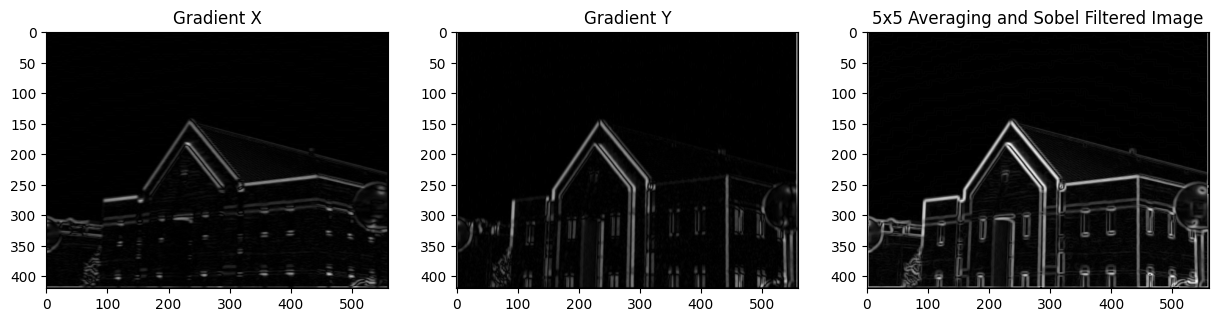

In [ ]:
import numpy as np

#performing convolution based on the image dimensions and kernel size
def convolution(image, kernel):
    height, width = image.shape
    ksize = kernel.shape[0]
    pad = ksize // 2
    padded_image = np.pad(image, pad, mode='constant')
    output = np.zeros_like(image)

    for i in range(height):
        for j in range(width):
            output[i, j] = np.sum(padded_image[i:i+ksize, j:j+ksize] * kernel)

    return output

#function which applies a 5x5 averaging smoothing filter
def applySmoothingAndSobel(input_image):

    averaging_filter = np.ones((5, 5), dtype=np.float32) / 25.0
    smoothed_image = convolution(input_image, averaging_filter)
    newgradient_x, newgradient_y, newsobel_image = sobelOperator(smoothed_image)

    return newgradient_x, newgradient_y, newsobel_image

newgradient_x, newgradient_y, newsobel_image = applySmoothingAndSobel(input_image)

newsobel_image = cv2.cvtColor(newsobel_image.astype(np.uint8), cv2.COLOR_GRAY2BGR)

fig, axis = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axis[0].imshow(np.abs(newgradient_x), cmap='gray')
axis[0].set_title('Gradient X')
axis[1].imshow(np.abs(newgradient_y), cmap='gray')
axis[1].set_title('Gradient Y')
axis[2].imshow(newsobel_image, cmap='gray')
axis[2].set_title('5x5 Averaging and Sobel Filtered Image')

plt.show()


c)	Apply thresholding on the output image of part a) and b)

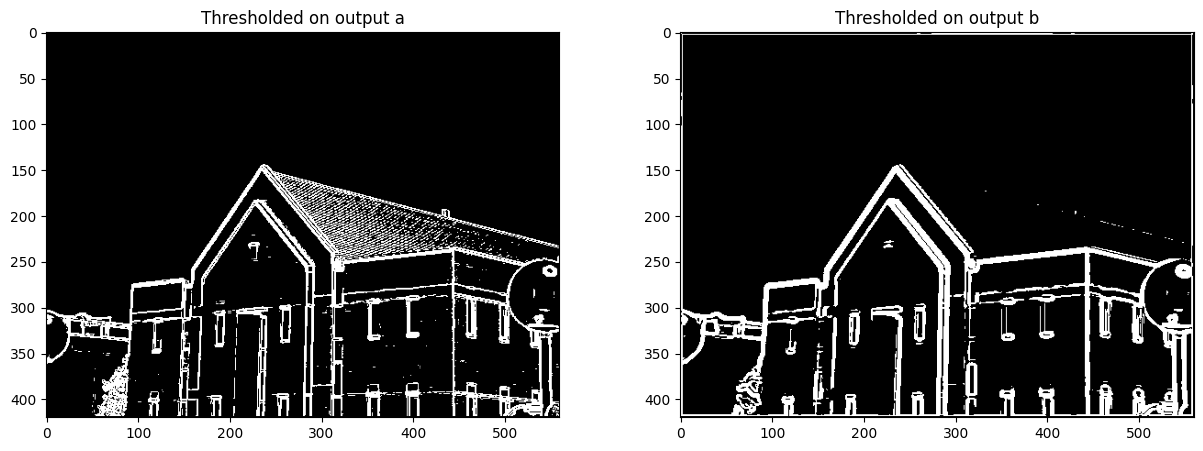

In [ ]:
#this function creates a binary image based on the threshold value given
def applyThreshold(image, threshold_value):
    binary_image = np.zeros_like(image)
    binary_image[image >= threshold_value] = 255

    return binary_image

#chosen these values for thick edges, can be changed
threshold_value1 = 70
threshold_value2 = 50

#threshlding applied on sobel and averag filter sobel images
thresholded_image1 = applyThreshold(sobel_image, threshold_value1)
thresholded_image2 = applyThreshold(newsobel_image, threshold_value2)

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axis[0].imshow(thresholded_image1, cmap='gray')
axis[0].set_title('Thresholded on output a')
axis[1].imshow(thresholded_image2, cmap='gray')
axis[1].set_title('Thresholded on output b')

plt.show()

d)	Marr-Hildreth edge detector

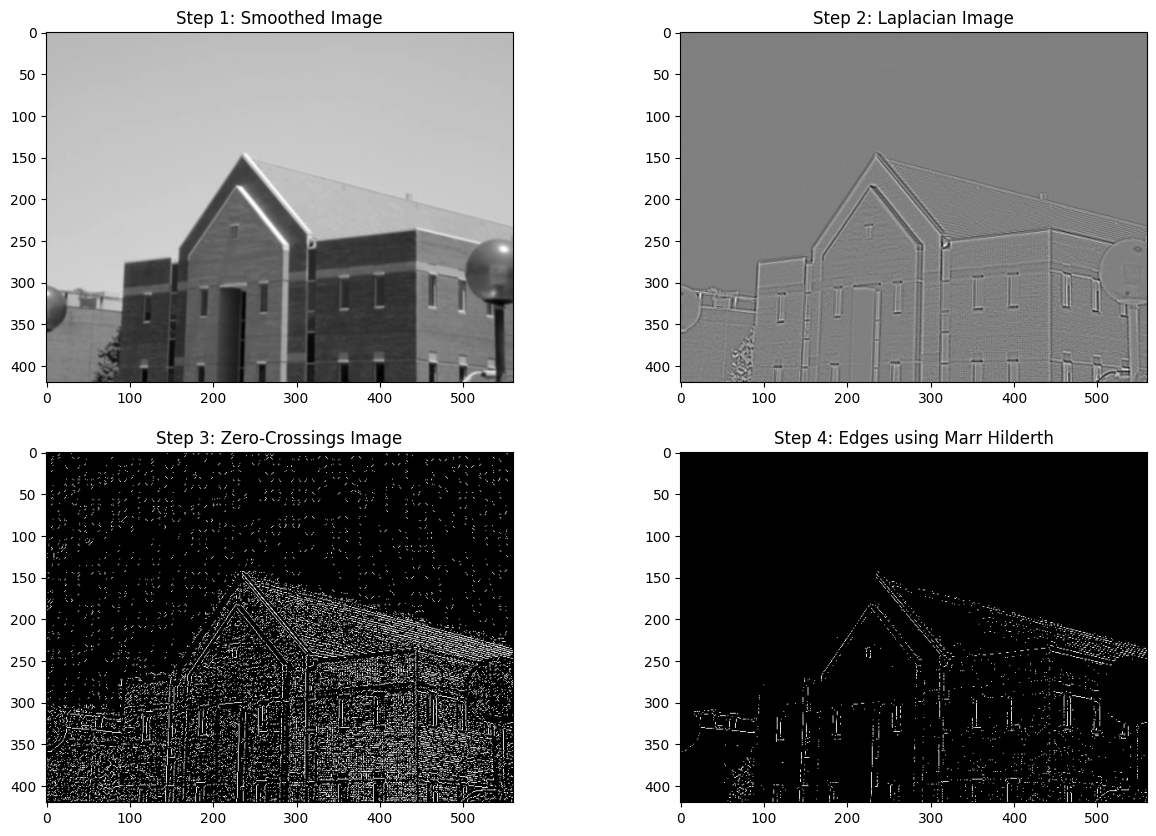

In [ ]:
#followed the steps mention in the book which are
# Step 1: Apply Gaussian smoothing to the gradient image
# Step 2: Compute the Laplacian of the smoothed image
# Step 3: Find zero-crossings in the Laplacian image
def MarrHildrethEdgeDetector(input_image, sigma):
    smoothed_image = cv2.GaussianBlur(input_image, (3, 3), sigma)
    laplacian = cv2.Laplacian(smoothed_image, cv2.CV_64F)

    zero_crossings = np.zeros_like(laplacian)
    zero_crossings[np.where(np.diff(np.signbit(laplacian), axis=0))] = 255
    zero_crossings[np.where(np.diff(np.signbit(laplacian), axis=1))] = 255
    threshold_value = 1.5
    zero_crossings = np.where(laplacian >threshold_value , zero_crossings, 0).astype(np.uint8)

    zero_crossings2 = np.zeros_like(laplacian)
    zero_crossings2[np.where(np.diff(np.signbit(laplacian), axis=0))] = 255
    zero_crossings2[np.where(np.diff(np.signbit(laplacian), axis=1))] = 255
    threshold_value2 = 7.5
    zero_crossings2 = np.where(laplacian > threshold_value2, zero_crossings, 0).astype(np.uint8)

    return smoothed_image, laplacian, zero_crossings, zero_crossings2

sigma = 4.0

#Marr Hilderth edge detector applied on the input image
smoothed_image, laplacian, zero_crossings, zero_crossings2 = MarrHildrethEdgeDetector(input_image, sigma)

#outputs which are smoothed, laplacian, zero-crossings and edges using marr hildert image
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axis[0, 0].imshow(smoothed_image, cmap='gray')
axis[0, 0].set_title('Step 1: Smoothed Image')
axis[0, 1].imshow(laplacian, cmap='gray')
axis[0, 1].set_title('Step 2: Laplacian Image')
axis[1, 0].imshow(zero_crossings, cmap='gray')
axis[1, 0].set_title('Step 3: Zero-Crossings Image')
axis[1, 1].imshow(zero_crossings2, cmap='gray')
axis[1, 1].set_title('Step 4: Edges using Marr Hilderth')

plt.show()

d) Canny Edge Detection


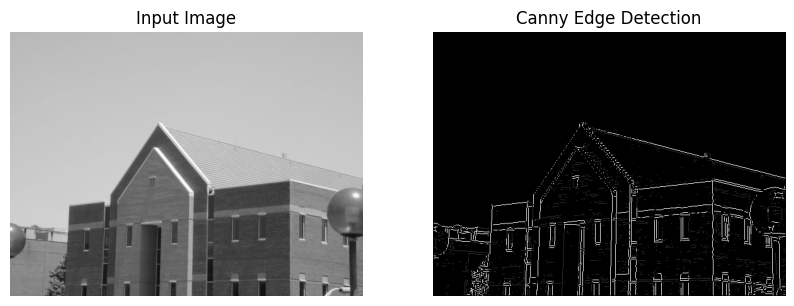

In [ ]:
#sobel operator using gaussian smoothing and calculating the gradients x and y, gives magnitude and direction
def sobel_operator(image):
    blurred = cv2.GaussianBlur(input_image, (3, 3), 4)

    gradient_x = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    gradient_magnitude = np.sqrt(gradient_x ** 2 + gradient_y ** 2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_direction


def non_max_suppression(gradient_magnitude, gradient_direction):
    gradient_direction = np.rad2deg(gradient_direction) % 180
    suppressed_image = np.zeros_like(gradient_magnitude)

    rows, cols = gradient_magnitude.shape
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            angle = gradient_direction[i, j]

            if (0 <= angle < 22.5) or (157.5 <= angle <= 180):
                q = gradient_magnitude[i, j + 1]
                r = gradient_magnitude[i, j - 1]
            elif 22.5 <= angle < 67.5:
                q = gradient_magnitude[i + 1, j - 1]
                r = gradient_magnitude[i - 1, j + 1]
            elif 67.5 <= angle < 112.5:
                q = gradient_magnitude[i + 1, j]
                r = gradient_magnitude[i - 1, j]
            else:
                q = gradient_magnitude[i - 1, j - 1]
                r = gradient_magnitude[i + 1, j + 1]

            if (gradient_magnitude[i, j] >= q) and (gradient_magnitude[i, j] >= r):
                suppressed_image[i, j] = gradient_magnitude[i, j]

    return suppressed_image

def hysteresis_thresholding(suppressed_image, low_threshold, high_threshold):
    thresholded_image = np.zeros_like(suppressed_image)
    high_value = 255
    low_value = 50
    strong_edge_value = 255

    strong_edges = suppressed_image >= high_threshold
    thresholded_image[strong_edges] = strong_edge_value

    weak_edges = (suppressed_image >= low_threshold) & (suppressed_image < high_threshold)
    thresholded_image[weak_edges] = low_value

    return thresholded_image

#sobel on input image
gradient_magnitude, gradient_direction = sobel_operator(input_image)

#suppressing image using non maximum suppression
suppressed_image = non_max_suppression(gradient_magnitude, gradient_direction)

#hystersis thresholing
low_threshold = 0.05 * np.max(suppressed_image)
high_threshold = 0.15 * np.max(suppressed_image)
thresholded_image = hysteresis_thresholding(suppressed_image, low_threshold, high_threshold)

#Ouputs which are input and canny edge detected image
fig, axis = plt.subplots(1, 2, figsize=(10, 5))
axis[0].imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
axis[0].set_title('Input Image')
axis[0].axis('off')
axis[1].imshow(thresholded_image, cmap='gray')
axis[1].set_title('Canny Edge Detection')
axis[1].axis('off')
plt.show()